# Hotel booking

### Predicting cancelations
It would be nice for the hotels to have a model to predict if a guest will actually come.  
This can help a hotel to plan things like personel and food requirements.  
Maybe some hotels also use such a model to offer more rooms than they have to make more money... who knows...

Setup, data inspection and cleanup are hidden for easier reading. Click the Code/Output buttons if you are curious.

In [1]:
# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest schould be self-explanatory.
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = full_data.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
full_data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entreis with 0 adults, 0 children and 0 babies. 
# We are dropping these entries with no guests.
zero_guests = list(full_data_cln.loc[full_data_cln["adults"]
                   + full_data_cln["children"]
                   + full_data_cln["babies"]==0].index)
full_data_cln.drop(full_data_cln.index[zero_guests], inplace=True)

full_data_cln.shape

rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]
ch = full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]

## 1. Predict cancelations  

Which numerical features are most important? 

In [2]:
cancel_corr = full_data.corr(numeric_only = True)["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [3]:
cancel_corr = full_data.corr(numeric_only = True)["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.  
However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.  
I will also not include days_in_waiting_list and arrival_date_year.  
  
The most important feature to exclude is the "reservation_status":

In [4]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: count, dtype: int64

### Comparing different base models:

In [21]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [26]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X_train, y_train, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    model_steps.fit(X_train, y_train)
    preds = model_steps.predict(X_test)
    score = accuracy_score(y_test, preds)
    print(f"{name} accuracy_score: {round(score, 4)}")
    

DT_model cross validation accuarcy score: 0.8182 +/- 0.0019 (std) min: 0.8159, max: 0.8206
DT_model accuracy_score: 0.8265
RF_model cross validation accuarcy score: 0.8617 +/- 0.0012 (std) min: 0.8596, max: 0.8629
RF_model accuracy_score: 0.8697


/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LR_model cross validation accuarcy score: 0.7952 +/- 0.0027 (std) min: 0.7909, max: 0.7979


/home/vscode/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR_model accuracy_score: 0.794
XGB_model cross validation accuarcy score: 0.846 +/- 0.0018 (std) min: 0.8437, max: 0.8484
XGB_model accuracy_score: 0.8452


In [50]:
predictor = Pipeline(steps=[('preprocessor', preprocessor),
                              base_models[1][1]])

In [53]:
[item[0] fir    °predictor.predict_proba(X_test)

array([[1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       ...,
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.        , 1.        ]])

ValueError: x and y must be the same size

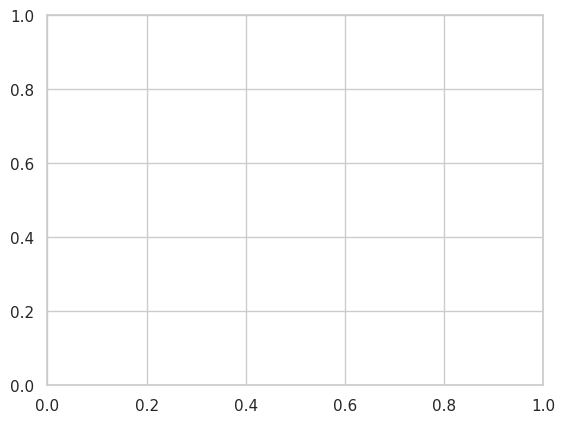

In [54]:
plt.scatter(y_test, predictor.predict_proba(X_test))